1. EDA + preprocessing

In [39]:
#사용할 모듈 라이브러리 모음
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import statsmodels.api as sm
import scipy.stats

from sklearn.metrics import r2_score,mean_squared_error

%matplotlib inline
plt.style.use('seaborn-pastel')

from math import sqrt
from statsmodels.graphics import utils
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
#사용할 데이터의 경로와 데이터 불러오기
file_train = '/content/drive/MyDrive/Colab Notebooks/영화관객수/movies_train.csv'
file_test = '/content/drive/MyDrive/Colab Notebooks/영화관객수/movies_test.csv'

df = pd.read_csv(file_train)
df_test = pd.read_csv(file_test)

In [3]:
#train data에 대한 개괄적인 정보
print('학습데이터의 크기:',df.shape,'\n')
print('검증데이터의 크기:',df_test.shape,'\n')
print(df.columns, '\n')
display(df.info(),'\n')
display(df.describe(), '\n')
display(df.head(3))
print('\n')
display(df_test.head(3))


학습데이터의 크기: (600, 12) 

검증데이터의 크기: (243, 11) 

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: floa

None

'\n'

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


'\n'

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [4]:
#null 값 수 확인 
df.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [5]:
#dir_prev_num의 정체 확인 
df[df['dir_prev_num']== 0]['dir_prev_bfnum'].isnull()

0      True
6      True
8      True
9      True
10     True
       ... 
593    True
594    True
597    True
598    True
599    True
Name: dir_prev_bfnum, Length: 330, dtype: bool

In [6]:
df.fillna(0)

print(df.isnull().sum())

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64


In [7]:
# 배급사와 장르는 영화 흥행 예측 연구에서 고전적으로 중요한 요소
# 따라서 모델링에 가능하면 포함시킬 수 있도록 데이터를 파악해보고 전처리 할것 
noms = []
nums = []
for column in df.columns:
  if df[column].dtype == 'object':
    noms.append(column)
  else: 
    nums.append(column)

print('noms, 범주형')
print(noms)
print('nums, 수치형')
print(nums)



noms, 범주형
['title', 'distributor', 'genre', 'release_time', 'screening_rat', 'director']
nums, 수치형
['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num']


In [8]:
# 배급사 값 확인
df['distributor'].value_counts()

CJ 엔터테인먼트    54
롯데엔터테인먼트     52
(주)NEW       30
(주)마운틴픽쳐스    29
(주)쇼박스       26
             ..
스튜디오 블루       1
스폰지이엔티        1
(주)씨엠닉스       1
프로젝트 엠피       1
필름라인          1
Name: distributor, Length: 169, dtype: int64

In [9]:
#배급사 전처리1 
df['distributor'] = df.distributor.str.replace("(주)", '')
df_test['distributor'] = df_test.distributor.str.replace("(주)", '')

df['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in df.distributor]
df_test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in df_test.distributor]





In [10]:
# 배급사 전처리2 --> 대형 자본의 경우 자회사가 많을 수 있으니 모회사를 기준으로 통일함

def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [11]:
# 배급사 전처리3
df['distributor'] = df.distributor.apply(get_dis)
df_test['distributor'] = df_test.distributor.apply(get_dis)

In [12]:
#장르 전처리 --> 랭킹으로 환산
display(df.groupby('genre').box_off_num.mean().sort_values())

print('\n')

df['genre_rank'] = df.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
df_test['genre_rank'] = df_test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

df_nm_rank = df.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
df_nm_rank

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [13]:
#배급사 랭킹에 대한 데이터 병합
df = pd.merge(df, df_nm_rank, how = 'left')
df_test = pd.merge(df_test, df_nm_rank, how = 'left')
df['dir_prev_bfnum'].fillna(0, inplace = True)
df_test['dir_prev_bfnum'].fillna(0, inplace = True)

print(df.shape,'\n')
print(df.isnull().sum(),'\n')
df.head(3)

(600, 14) 

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
genre_rank        0
num_rank          0
dtype: int64 



,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11,612772.0
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,2138560.0
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,2138560.0


In [14]:
#train data에 대한 개괄적인 정보
print('학습데이터의 크기:',df.shape,'\n')
print('검증데이터의 크기:',df_test.shape,'\n')
print(df.columns, '\n')
display(df.info(),'\n')
display(df.describe(), '\n')
display(df.head(3))
print('\n')
display(df_test.head(3))


학습데이터의 크기: (600, 14) 

검증데이터의 크기: (243, 13) 

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num', 'genre_rank', 'num_rank'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  600 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-nu

None

'\n'

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05,6.790000,3.951986e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06,2.801603,5.817890e+05
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,1.000000,2.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03,5.000000,1.379750e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04,8.000000,1.190450e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05,8.000000,6.136915e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07,12.000000,3.117859e+06


'\n'

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11,612772.0
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,2138560.0
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,2138560.0


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,genre_rank,num_rank
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,12,478291.5
1,아빠가 여자를 좋아해,쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,5,2138560.0
2,하모니,CJ,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,8,1084269.0


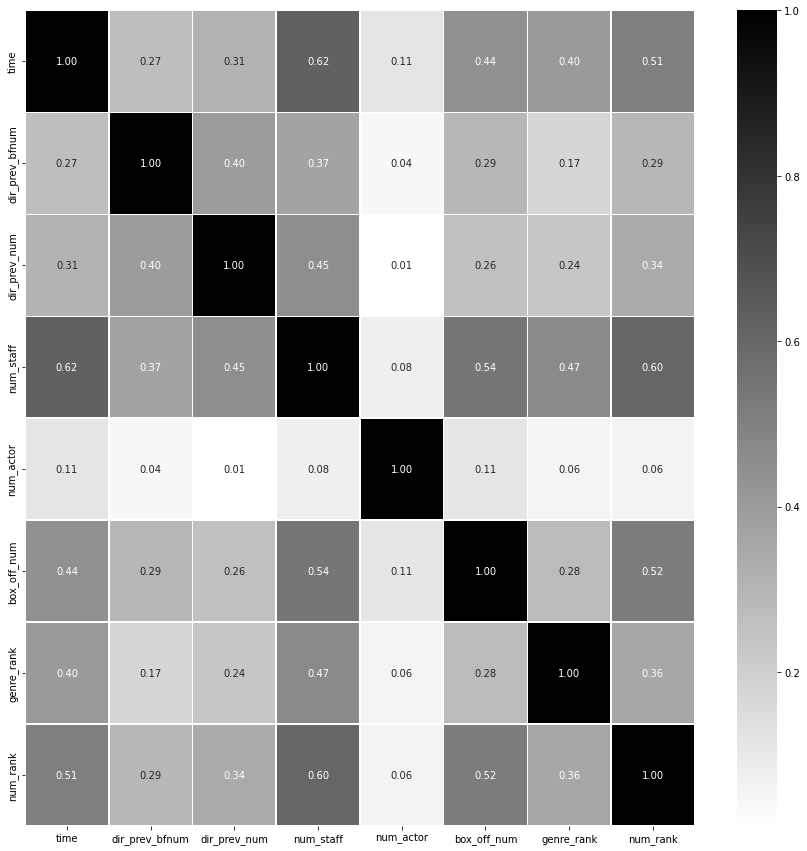

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='binary')


In [16]:
#correlation table
df.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452,0.404035,0.510779
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791,0.174314,0.294757
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674,0.236391,0.341813
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265,0.466936,0.604596
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179,0.058944,0.061599
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000,0.279454,0.522017
genre_rank,0.404035,0.174314,0.236391,0.466936,0.058944,0.279454,1.000000,0.356244
num_rank,0.510779,0.294757,0.341813,0.604596,0.061599,0.522017,0.356244,1.000000


In [17]:
print(df['box_off_num'].mean(),'\n')
print(df['box_off_num'].median())

708181.7516666667 

12591.0


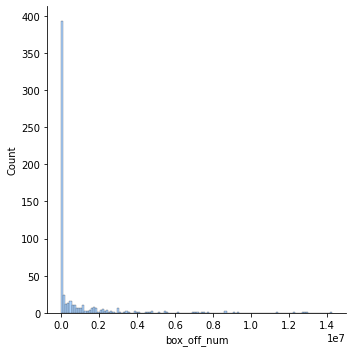

In [18]:
sns.displot(df['box_off_num'])

0       28.601770
1      191.951277
2      190.919669
3       60.172283
4       78.481083
          ...    
595    113.834247
596    119.731762
597     13.526696
598    129.911676
599    192.798218
Name: box_off_num, Length: 600, dtype: float64




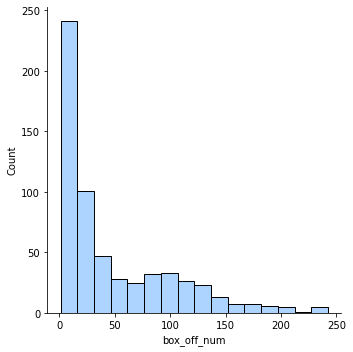

In [19]:
print(np.cbrt(df['box_off_num']))
print('\n')
sns.displot(np.cbrt(df['box_off_num']))

In [20]:
#수치형과 범주형 나누기 

noms = []
nums = []

#df.columns --> iterable : loop를 사용할 수 있다
#loop를 사용해서 각 noms와 nums의 칼럼을 넣어줌 
for column in df.columns:
  if df[column].dtype == 'object':
    noms.append(column)
  else: 
    nums.append(column)

print('noms, 범주형')
print(noms)
print('nums, 수치형')
print(nums)

noms, 범주형
['title', 'distributor', 'genre', 'release_time', 'screening_rat', 'director']
nums, 수치형
['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'genre_rank', 'num_rank']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f928b447350>,
      dtype=object)

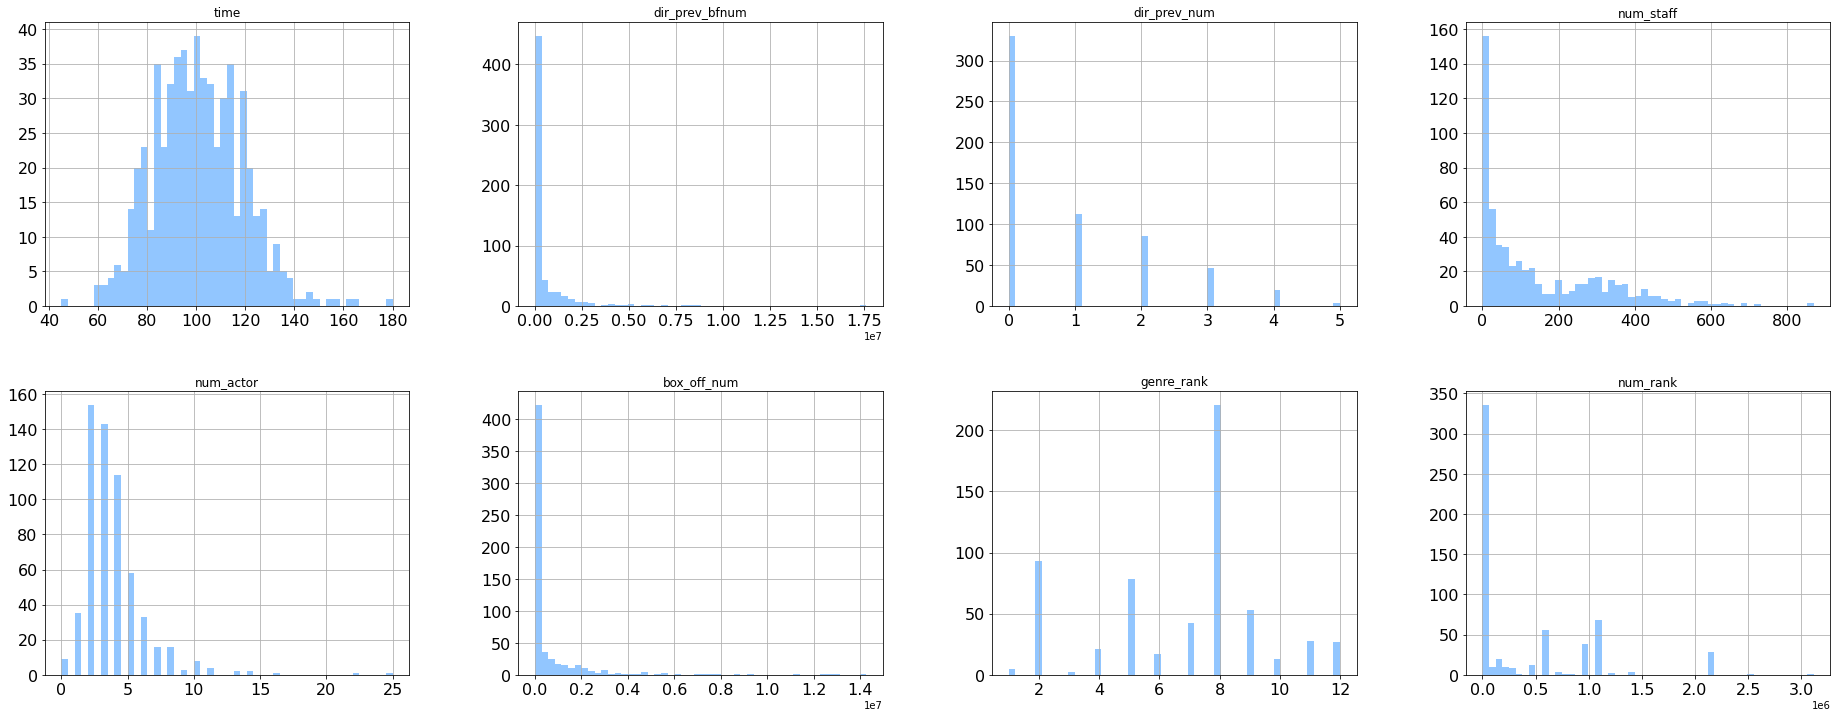

In [21]:
#수치형 데이터들의 히스토그램--> 데이터 분포 확인 
df_noms = df[noms].copy()
df_nums = df[nums].copy()

df_nums.hist(figsize=(32,12), bins=50, layout=(2,4), xlabelsize = 16, ylabelsize = 16)

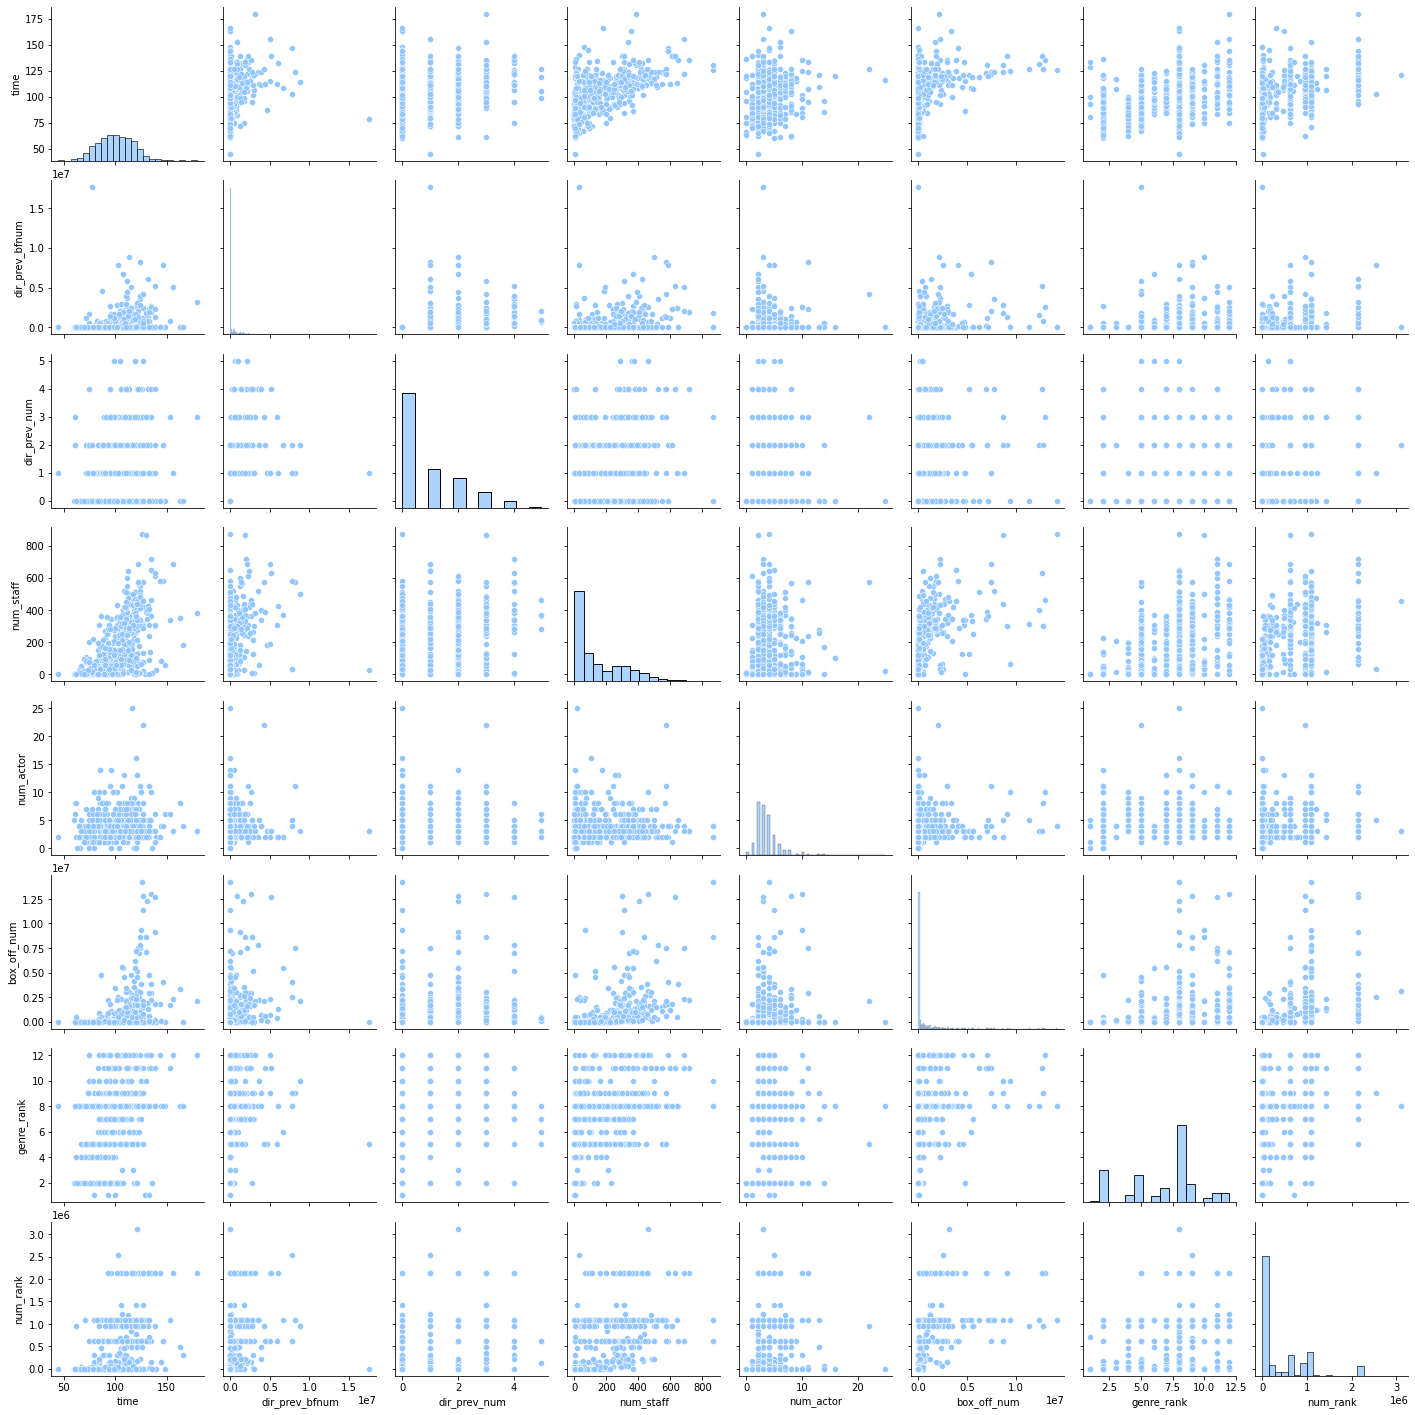

In [22]:
# 수치형 데이터 들의 산점도
sns.pairplot(data = df_nums)

In [23]:
for col in nums:
    df_nums_corr = df_nums.corr()[col].drop(col, axis=0)
    good_features = df_nums_corr[abs(df_nums_corr) > 0.0].sort_values(ascending=False)
    print('\nCorrelations with {} : \n{}'.format(col, good_features))


Correlations with time : 
num_staff         0.623205
num_rank          0.510779
box_off_num       0.441452
genre_rank        0.404035
dir_prev_num      0.306727
dir_prev_bfnum    0.266065
num_actor         0.114153
Name: time, dtype: float64

Correlations with dir_prev_bfnum : 
dir_prev_num    0.396616
num_staff       0.369657
num_rank        0.294757
box_off_num     0.293791
time            0.266065
genre_rank      0.174314
num_actor       0.042491
Name: dir_prev_bfnum, dtype: float64

Correlations with dir_prev_num : 
num_staff         0.450706
dir_prev_bfnum    0.396616
num_rank          0.341813
time              0.306727
box_off_num       0.259674
genre_rank        0.236391
num_actor         0.014006
Name: dir_prev_num, dtype: float64

Correlations with num_staff : 
time              0.623205
num_rank          0.604596
box_off_num       0.544265
genre_rank        0.466936
dir_prev_num      0.450706
dir_prev_bfnum    0.369657
num_actor         0.077871
Name: num_staff, dtype: floa

In [24]:
#왜도와 첨도 계산
for col in nums:
    print('skewness of {}: {}'.format(col, skew(df[col])))
    print('kurtosis of {}: {}\n'.format(col, kurtosis(df[col])))

skewness of time: 0.3447840297735809
kurtosis of time: 0.5319240780637076

skewness of dir_prev_bfnum: 6.173486868021442
kurtosis of dir_prev_bfnum: 57.93361903615163

skewness of dir_prev_num: 1.2496276916957825
kurtosis of dir_prev_num: 0.7061861628192974

skewness of num_staff: 1.2303665582484267
kurtosis of num_staff: 1.0845102642510867

skewness of num_actor: 2.943286008621123
kurtosis of num_actor: 16.467020719492517

skewness of box_off_num: 4.321279878093952
kurtosis of box_off_num: 21.75338007994831

skewness of genre_rank: -0.3731116136075192
kurtosis of genre_rank: -0.5875112731131127

skewness of num_rank: 1.6282069333122984
kurtosis of num_rank: 2.346294846751915




Modeling

In [25]:
#독립변수와 종속변수의 분할, 상영등급의 더미화
X = df[['num_rank', 'time', 'num_staff', 'num_actor', 'dir_prev_bfnum','screening_rat','genre_rank','dir_prev_num']]
y = df.box_off_num
X = pd.get_dummies(columns = ['screening_rat'], data = X)

#train data와 test data의 분리
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2, random_state= 29)



In [26]:
#OLS model을 이용한 확인1
X_train= sm.add_constant(X_train)
est = sm.OLS(y_train, X_train)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            box_off_num   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     27.62
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           1.79e-41
Time:                        12:30:42   Log-Likelihood:                -7460.7
No. Observations:                 480   AIC:                         1.494e+04
Df Residuals:                     469   BIC:                         1.499e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.278e+06   3.56e+05     -3.591      0.000   -1.98e+06   -5.78e+05
num_rank                   0.8207      0.144      5.694      0.000       0.537       1.104
time                    1.223e+04   4775.572      2.560      0.011    2842.861    2.16e+04
num_staff               2375.5988    592.921      4.007      0.000    1210.488    3540.710
num_actor               5.656e+04   2.65e+04      2.138      0.033    4567.489    1.09e+05
dir_prev_bfnum             0.1490      0.050      2.983      0.003       0.051       0.247
genre_rank              2.093e+04   2.86e+04      0.731      0.465   -3.53e+04    7.71e+04
dir_prev_num           -5.619e+04   6.13e+04     -0.917      0.360   -1.77e+05    6.43e+04
screening_rat_12세 관람가  -3.824e+05   1.62e+05     -2.356      0.019   -7.01e+05   -6.35e+04
screening_rat_15세 관람가  -1.896e+05   1.51e+05     -1.255      0.210   -4.87e+05    1.07e+05
screening_rat_전체 관람가    -2.18e+05   1.58e+05     -1.377      0.169   -5.29e+05    9.31e+04
screening_rat_청소년 관람불가 -4.875e+05   1.43e+05     -3.421      0.001   -7.68e+05   -2.07e+05
==============================================================================
Omnibus:                      418.256   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10078.616
Skew:                           3.753   Prob(JB):                         0.00
Kurtosis:                      24.156   Cond. No.                     5.66e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.4e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
#모델2
#독립변수와 종속변수의 분할
X = df[['num_rank', 'time', 'num_staff', 'num_actor', 'dir_prev_bfnum']]
y = df.box_off_num


#train data와 test data의 분리
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2, random_state= 29)

#OLS model을 이용한 확인
X_train= sm.add_constant(X_train)
est3 = sm.OLS(y_train, X_train)
est4 = est3.fit()
est4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            box_off_num   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     54.30
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           1.50e-44
Time:                        12:30:42   Log-Likelihood:                -7463.1
No. Observations:                 480   AIC:                         1.494e+04
Df Residuals:                     474   BIC:                         1.496e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.589e+06   4.31e+05     -3.692      0.000   -2.44e+06   -7.43e+05
num_rank           0.8631      0.142      6.079      0.000       0.584       1.142
time            1.271e+04   4689.623      2.710      0.007    3493.692    2.19e+04
num_staff       2334.3639    554.312      4.211      0.000    1245.152    3423.576
num_actor       6.224e+04   2.63e+04      2.366      0.018    1.05e+04    1.14e+05
dir_prev_bfnum     0.1372      0.049      2.819      0.005       0.042       0.233
==============================================================================
Omnibus:                      424.886   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10591.987
Skew:                           3.833   Prob(JB):                         0.00
Kurtosis:                      24.699   Cond. No.                     1.03e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


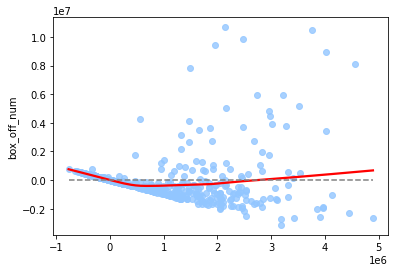

In [28]:
# 모형의 선형성 확인
lr = LinearRegression()
lr.fit(X,y)
fitted = lr.predict(X)
residual = df['box_off_num'] - fitted 

sns.regplot(fitted, residual, lowess = True, line_kws={'color' : 'red'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color='gray')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


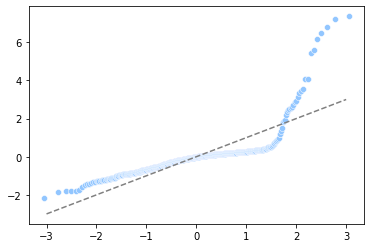

In [30]:
#잔차의 정규성 Q-Q plot
sr= scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color = 'gray')

3.815715501670186
21.626054750779993


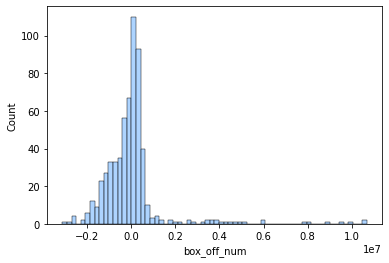

In [31]:
# 잔차의 정규성은 histogram
print(residual.skew())
print(residual.kurtosis())

sns.histplot(data = residual)

In [32]:
#VIF확인 
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


          feature       VIF
0        num_rank  2.354525
1            time  4.842041
2       num_staff  3.369185
3       num_actor  3.280869
4  dir_prev_bfnum  1.321937


In [33]:
#독립변수와 종속변수의 분할
X = df[['num_rank', 'time', 'num_staff', 'num_actor', 'dir_prev_bfnum']]
y = df.box_off_num
# 변수간의 중요도 파악을 위해 표준화 실시 후 모델2-->표준화 단계
scaler = StandardScaler()
X_s = X.copy() # 원본 재활용을 위해 X 복사 
scaler.fit(X_s)
X_scaled = scaler.transform(X_s)


X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
print(X_scaled)
print(f'평균\n{X_scaled.mean()}')
print(f'분산\n{X_scaled.var()}')



     num_rank      time  num_staff  num_actor  dir_prev_bfnum
0    0.374285 -0.268953  -0.363216  -0.698066       -0.361285
1    2.999053  1.611324   1.425124  -0.289043        0.526530
2    2.999053  1.224208   1.159290   0.119980       -0.192546
3    0.962825  0.007558  -0.792176   0.938026       -0.343023
4    2.999053  0.394674   0.603454  -0.698066       -0.361284
..        ...       ...        ...        ...             ...
595  0.962825  0.560581   2.168252   1.347050       -0.358356
596  2.999053  1.445417   0.814913   0.938026        0.017855
597 -0.677788 -0.103047  -0.169882   0.119980       -0.361285
598  1.185387  0.062860   1.690959   0.119980       -0.361285
599  1.185387  1.058301   1.280124   0.529003       -0.361285

[600 rows x 5 columns]
평균
num_rank         -3.182639e-17
time              1.661634e-16
num_staff        -6.994405e-17
num_actor         8.252658e-17
dir_prev_bfnum   -3.386180e-17
dtype: float64
분산
num_rank          1.001669
time              1.001669
nu

In [34]:

#train data와 test data의 분리
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y, test_size= 0.2, random_state= 29)

#OLS model을 이용한 확인
est5 = sm.OLS(y_train, X_train)
est6 = est5.fit()
est6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            box_off_num   R-squared (uncentered):                   0.312
Model:                            OLS   Adj. R-squared (uncentered):              0.305
Method:                 Least Squares   F-statistic:                              43.17
Date:                Tue, 14 Dec 2021   Prob (F-statistic):                    1.12e-36
Time:                        12:33:45   Log-Likelihood:                         -7516.3
No. Observations:                 480   AIC:                                  1.504e+04
Df Residuals:                     475   BIC:                                  1.506e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
num_rank        4.884e+05   9.21e+04      5.303      0.000    3.07e+05    6.69e+05
time             2.23e+05   9.46e+04      2.356      0.019     3.7e+04    4.09e+05
num_staff       3.969e+05   1.02e+05      3.877      0.000    1.96e+05    5.98e+05
num_actor        1.47e+05   7.18e+04      2.048      0.041    5952.881    2.88e+05
dir_prev_bfnum  1.851e+05   7.11e+04      2.605      0.009    4.54e+04    3.25e+05
==============================================================================
Omnibus:                      427.011   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10779.431
Skew:                           3.857   Prob(JB):                         0.00
Kurtosis:                      24.896   Cond. No.                         2.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


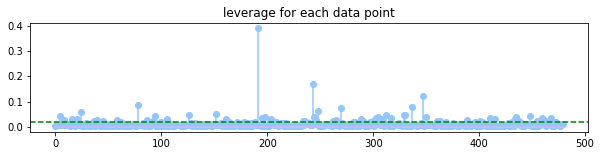

6.00000000000014

In [35]:
#레버리지 파악
influence = est4.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10,2))
plt.stem(hat)
plt.axhline(0.02, c='g', ls='--')
plt.title('leverage for each data point')
plt.show()

hat.sum()

In [36]:
#cooks Distance
cooks_d2, pvals = influence.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_

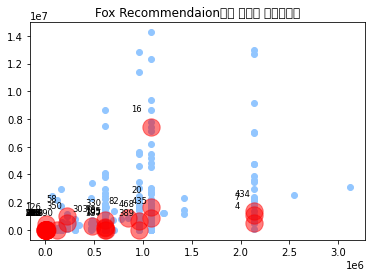

In [37]:
ax = plt.subplot()
plt.scatter(df['num_rank'], df['box_off_num'])
plt.scatter(df['num_rank'][idx], df['box_off_num'][idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(df['num_rank'][idx], df['box_off_num'][idx])), [(-20, 15)] * len(idx), size="small", ax=ax) ### (-20,15)는 offset points 즉 네이밍 위치를 어디에 둘 것인가 하는 명령어
plt.title("Fox Recommendaion으로 선택한 아웃라이어")
plt.show()

In [38]:
#df.drop(idx, inplace=True)



Train & Test

In [40]:
#모델2
#독립변수와 종속변수의 분할
X = df[['num_rank', 'time', 'num_staff', 'num_actor', 'dir_prev_bfnum']]
y = df.box_off_num


#train data와 test data의 분리
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2, random_state= 29)

#sklearn을 이용한 확인 
lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)
rmse =  sqrt(mean_squared_error(y_test, predict))

In [41]:
rmse

1754519.7746736226